In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error
sns.set(font='Arial')

In [23]:
df = pd.read_csv('..\\data\\pareto\\avg_price_act.csv',index_col=0)
df=df.join(pd.read_csv('..\\data\\pareto\\avg_price_sa.csv',index_col=0))

df.index=df.index.rename('Date')
df.index=pd.DatetimeIndex(df.index)

<AxesSubplot:title={'center':'Avg Price'}, xlabel='Date'>

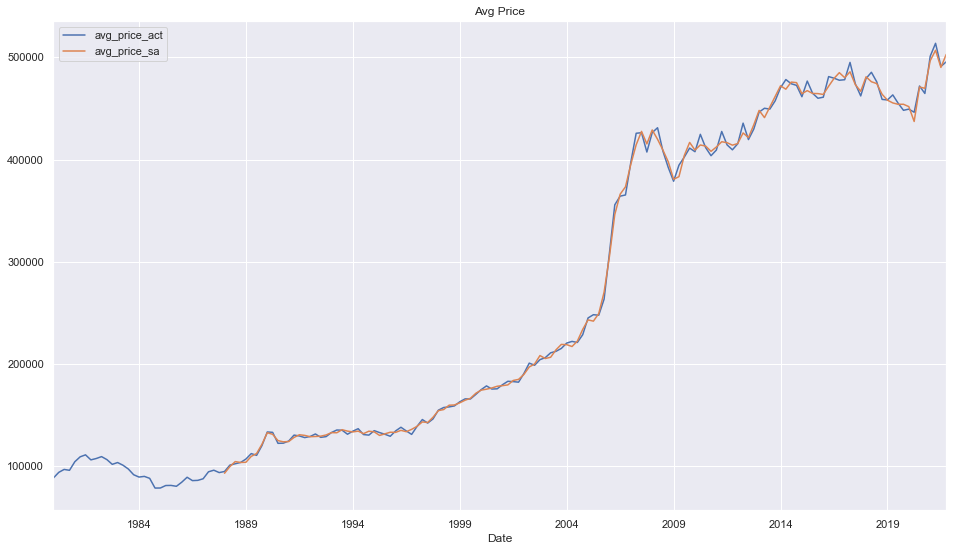

In [24]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,9))

df[['avg_price_act','avg_price_sa']].plot(ax=ax,title='Avg Price')


In [25]:
real_income = pd.read_excel('../data/BaselineProvincialForecasts.xlsx',sheet_name='RealDisposableIncome',engine='openpyxl',index_col=0)[['AB']]
real_income.rename({'AB':'RealDisposableIncome'},axis=1,inplace=True)

real_gdp = pd.read_excel('../data/BaselineProvincialForecasts.xlsx',sheet_name='RealGDP',engine='openpyxl',index_col=0)[['AB']]
real_gdp.rename({'AB':'RealGDP'},axis=1,inplace=True)

unemp = pd.read_excel('../data/BaselineProvincialForecasts.xlsx',sheet_name='Unemployment',engine='openpyxl',index_col=0)[['AB']]
unemp.rename({'AB':'Unemployment'},axis=1,inplace=True)

employment = pd.read_excel('../data/BaselineProvincialForecasts.xlsx',sheet_name='Employment',engine='openpyxl',index_col=0)[['AB']]
employment.rename({'AB':'Employment'},axis=1,inplace=True)

cpi = pd.read_excel('../data/BaselineProvincialForecasts.xlsx',sheet_name='CPI',engine='openpyxl',index_col=0,header=1)[['AB']]
cpi.rename({'AB':'CPI'},axis=1,inplace=True)

prov_econ=real_gdp.join(real_income)
prov_econ=prov_econ.join(unemp)
prov_econ=prov_econ.join(employment)
prov_econ=prov_econ.join(cpi)
prov_econ.index=prov_econ.index.rename('Date')
prov_econ.index=pd.PeriodIndex(prov_econ.index,freq='Q').to_timestamp()


In [26]:
df['avg_price_sa_log'] =np.log(df['avg_price_sa'])

In [32]:
df['avg_price_sa_log_diff']=df['avg_price_sa_log'].diff()

In [34]:
nat_econ=pd.read_excel('../data/BaselineNationalForecasts.xlsx',header=1,index_col=0,engine='openpyxl',sheet_name='Quarterly')[3:-11]
energy = pd.read_excel('../data/BaselineNationalForecasts.xlsx',sheet_name='Energy',header=0,index_col=0,engine='openpyxl')
covid = pd.read_excel('../data/BaselineNationalForecasts.xlsx',sheet_name='COVID',header=0,index_col=0,engine='openpyxl')

In [35]:
nat_econ.index = nat_econ.index.str.replace(' ','')
nat_econ.index=nat_econ.index.rename('Date')
nat_econ.index=pd.PeriodIndex(nat_econ.index,freq='Q').to_timestamp()
energy.index = energy.index.str.replace(' ','')
energy.index=energy.index.rename('Date')
energy.index=pd.PeriodIndex(energy.index,freq='Q').to_timestamp()
covid.index = covid.index.str.replace(' ','')
covid.index=covid.index.rename('Date')
covid.index=pd.PeriodIndex(covid.index,freq='Q').to_timestamp()


In [37]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean error':me, 'mae': mae, 
            'mean percentage error': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})
        

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

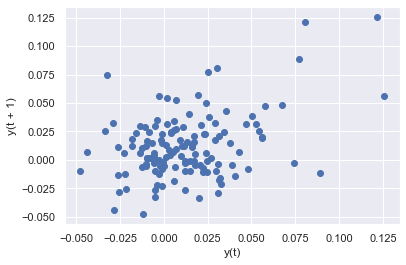

In [38]:
pd.plotting.lag_plot(df['avg_price_sa_log_diff']['1988':])


In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [39]:
test_df = nat_econ.join(energy).join(df).join(prov_econ).join(covid)

In [40]:
history_df=test_df['1988':'2021']


In [71]:
history_df['CPI']

Date
1988-01-01     67.536693
1988-04-01     68.005108
1988-07-01     68.145014
1988-10-01     68.519212
1989-01-01     69.220147
                 ...    
2020-10-01    145.512828
2021-01-01    146.352459
2021-04-01    148.191545
2021-07-01    150.536396
2021-10-01    151.981480
Freq: QS-OCT, Name: CPI, Length: 136, dtype: float64

RMSE: 0.030


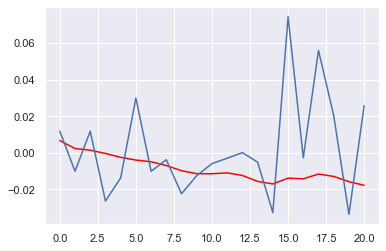

In [49]:
history_df=test_df['1988':'2021']
val = np.array(history_df[['avg_price_sa_log_diff']].values,dtype=float)
size = int(len(val)*0.85)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = np.array(history_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']].values,dtype=float)
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
exog_train = np.array(exog_train, dtype=float)
predictions = list()
model = SARIMAX(history,order=(1,1,1), seasonal_order=(0,0,0,0),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)

RMSE: 0.071


C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


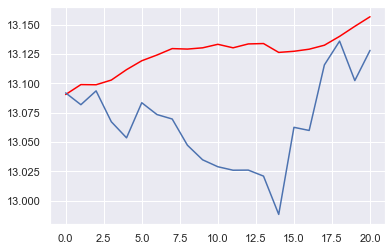

In [51]:
history_df=test_df['1988':'2021']
val = np.array(history_df[['avg_price_sa_log']].values,dtype=float)
size = int(len(val)*0.85)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = np.array(history_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']].values,dtype=float)
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
exog_train = np.array(exog_train, dtype=float)
predictions = list()
model = SARIMAX(history,order=(1,1,1), seasonal_order=(0,0,0,0),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)

In [53]:
np.exp(output.summary_frame()['mean'])

0     484311.241229
1     488427.678215
2     488362.679515
3     490316.716755
4     494692.059876
5     498458.900665
6     500898.816817
7     503655.019630
8     503447.126669
9     503985.688512
10    505501.824179
11    503992.904446
12    505662.234806
13    505829.588127
14    502018.296764
15    502502.113770
16    503395.198903
17    505108.246783
18    508940.706547
19    513310.520335
20    517526.394365
Name: mean, dtype: float64

In [54]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 258.947
Date:                Thu, 17 Feb 2022   AIC                           -503.893
Time:                        11:57:29   BIC                           -484.740
Sample:                             0   HQIC                          -496.120
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0001      0.000      0.342      0.733      -0.001       0.001
x2             0.0118      0.006      1.955      0.051   -2.75e-05       0.024
const               0   8.95e-16          0      1.000   -1.75e-15    1.75e-15
x3             0.0036      0.004      0.956      0.339      -0.004       0.011
ar.L1          0.4759      0.127      3.744      0.000       0.227       0.725
ma.L1          0.1130      0.152      0.742      0.458      -0.185       0.411
sigma2         0.0006   7.59e-05      8.171      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 2.07
Prob(Q):                              0.36   Prob(JB):                         0.35
Heteroskedasticity (H):               0.71   Skew:                             0.05
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.41e+20. Standard errors may be unstable.
"""

RMSE: 0.043


C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


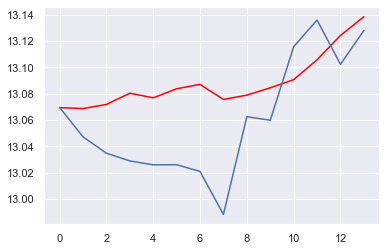

In [60]:
history_df=test_df['1988':'2021']
val = np.array(history_df[['avg_price_sa_log']].values,dtype=float)
size = int(len(val)*0.90)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = np.array(history_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']].values,dtype=float)
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
exog_train = np.array(exog_train, dtype=float)
predictions = list()
model = SARIMAX(history,order=(1,0,1), seasonal_order=(0,0,0,0),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)

C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE: 0.070


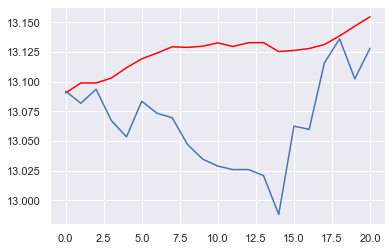

In [68]:
history_df=test_df['1988':'2021']
val = np.array(history_df[['avg_price_sa_log']].values,dtype=float)
size = int(len(val)*0.85)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = np.array(history_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']].values,dtype=float)
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
exog_train = np.array(exog_train, dtype=float)
predictions = list()
model = SARIMAX(history,order=(2,1,1), seasonal_order=(0,0,0,0),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)

In [69]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 259.140
Date:                Thu, 17 Feb 2022   AIC                           -502.279
Time:                        12:02:03   BIC                           -480.390
Sample:                             0   HQIC                          -493.395
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0001      0.000      0.362      0.718      -0.001       0.001
x2             0.0117      0.006      1.964      0.050    2.55e-05       0.023
const               0        nan        nan        nan         nan         nan
x3             0.0034      0.004      0.893      0.372      -0.004       0.011
ar.L1          0.2854      1.234      0.231      0.817      -2.134       2.704
ar.L2          0.1074      0.731      0.147      0.883      -1.325       1.540
ma.L1          0.3185      1.240      0.257      0.797      -2.112       2.749
sigma2         0.0006   7.58e-05      8.166      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                 2.08
Prob(Q):                              0.30   Prob(JB):                         0.35
Heteroskedasticity (H):               0.72   Skew:                             0.04
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.72e+19. Standard errors may be unstable.
"""

C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\makmi\AppData\Local\Temp/ipykernel_7540/3785809550.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(fcast_res[['mean']])


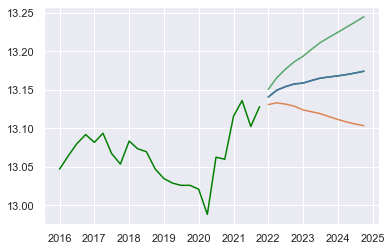

In [92]:

exog =  np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']]['1988':'2021'].values,dtype=float)
exog_fcast = np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']]['2022':'2024'].values,dtype=float)


model = SARIMAX(val,order=(1,1,1), seasonal_order=(0,0,0,0),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.7)
fcast_res.index= pd.date_range(start='2022',periods=12,freq='qs-oct')

history = test_df[['avg_price_sa_log']]['2016':]
history=history.append(fcast_res[['mean']])
#history.index = pd.date_range(start='2019',end='2025',freq='qs-oct')
plt.plot(history,color='green')

plt.plot(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2020':])

In [93]:
np.exp(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2020':])

y,mean,mean_ci_lower,mean_ci_upper
2022-01-01,509255.880498,504269.314893,514291.756731
2022-04-01,513754.933067,505405.824176,522241.966011
2022-07-01,516145.133973,504558.492312,527997.850365
2022-10-01,517926.463665,503192.696183,533091.644214
2023-01-01,518515.089638,500765.675937,536893.623308
2023-04-01,520264.867094,499567.276534,541819.980304
2023-07-01,521871.687318,498337.681414,546517.087070
2023-10-01,522663.881751,496441.664018,550271.165953
2024-01-01,523388.684149,494594.697816,553858.979694
2024-04-01,524287.856561,493020.169993,557538.561842


In [80]:
np.exp(history['2020':])

,avg_price_sa_log,mean
2020-01-01,451751.0,NaN
2020-04-01,437227.0,NaN
2020-07-01,470946.0,NaN
2020-10-01,469688.0,NaN
2021-01-01,496690.0,NaN
2021-04-01,506877.0,NaN
2021-07-01,490103.0,NaN
2021-10-01,502881.0,NaN
2022-01-01,NaN,NaN
2022-04-01,NaN,NaN


In [78]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  136
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 280.357
Date:                           Thu, 17 Feb 2022   AIC                           -544.715
Time:                                   12:06:33   BIC                           -521.713
Sample:                                        0   HQIC                          -535.368
                                           - 136                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0007      0.000      2.435      0.015       0.000       0.001
x2             0.0143      0.005      2.770      0.006       0.004       0.024
x3            -0.0088      0.015     -0.595      0.552      -0.038       0.020
x4            -0.0017      0.004     -0.410      0.682      -0.010       0.006
ar.L1          0.2709      0.176      1.543      0.123      -0.073       0.615
ma.L1          0.2602      0.174      1.497      0.134      -0.081       0.601
ma.S.L4       -0.7015      0.109     -6.457      0.000      -0.914      -0.489
sigma2         0.0008      0.000      7.815      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   3.40   Jarque-Bera (JB):                19.45
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.19
Prob(H) (two-sided):                  0.81   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\makmi\AppData\Local\Temp/ipykernel_7540/3198193336.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(fcast_res[['mean']])


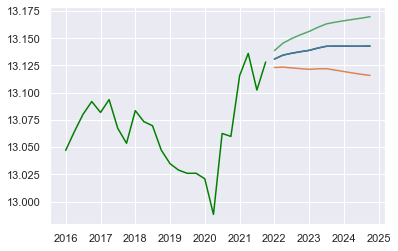

In [89]:

exog =  np.array(test_df[['Interest rate on fixed 5-year mortgages [%]']]['1988':'2021'].values,dtype=float)
exog_fcast = np.array(test_df[['Interest rate on fixed 5-year mortgages [%]']]['2022':'2024'].values,dtype=float)


model = SARIMAX(val,order=(1,0,0), seasonal_order=(0,0,0,0),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.8)
fcast_res.index= pd.date_range(start='2022',periods=12,freq='qs-oct')

history = test_df[['avg_price_sa_log']]['2016':]
history=history.append(fcast_res[['mean']])
#history.index = pd.date_range(start='2019',end='2025',freq='qs-oct')
plt.plot(history,color='green')

plt.plot(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2020':])

In [86]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  136
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 286.095
Date:                           Thu, 17 Feb 2022   AIC                           -562.190
Time:                                   12:34:49   BIC                           -547.814
Sample:                                        0   HQIC                          -556.348
                                           - 136                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0131      0.005      2.666      0.008       0.003       0.023
ar.L1          0.4190      0.179      2.342      0.019       0.068       0.770
ma.L1         -0.0261      0.201     -0.130      0.897      -0.419       0.367
ma.S.L4       -0.9980      1.962     -0.509      0.611      -4.844       2.848
sigma2         0.0007      0.001      0.508      0.611      -0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                21.32
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.35
Prob(H) (two-sided):                  0.91   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

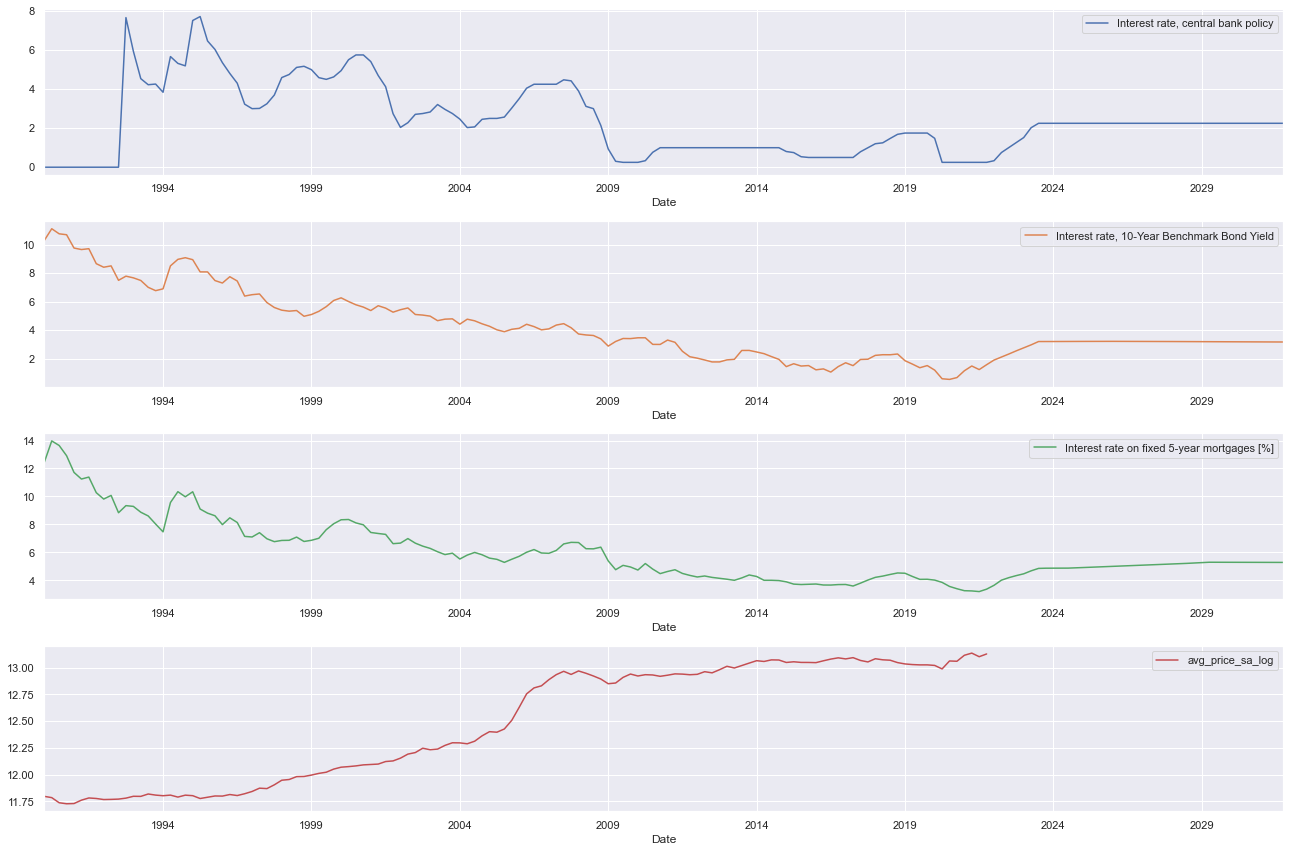

In [84]:

fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(18,12))
test_df['1990':][['Interest rate, central bank policy','Interest rate, 10-Year Benchmark Bond Yield','Interest rate on fixed 5-year mortgages [%]','avg_price_sa_log']].plot(ax=ax,subplots=True)
plt.tight_layout()